In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline

## Leitura do dataset

In [71]:
dataset = pd.read_csv('coverage-dataset4.csv', sep=';')
dataset.head(5)

,Name,CountInput,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountPath,...,CyclomaticStrict.1,Essential.1,Knots.1,MaxEssentialKnots.1,MaxNesting.1,MinEssentialKnots.1,RatioCommentToCode.1,EdgeCoverage,PrimePathCoverage,Unnamed: 50
0,com.puppycrawl.tools.checkstyle.Checker.clearC...,4,8,0,5,1,2,3,1,2,...,1,1,0,0,1,0,0.05,"0,0000",NaN,NaN
1,com.puppycrawl.tools.checkstyle.DefaultConfigu...,1169,14,0,9,2,5,5,2,2,...,1,1,0,0,1,0,0.05,"1,0000",NaN,NaN
2,com.puppycrawl.tools.checkstyle.Checker.destroy(),20,14,0,14,1,9,0,4,3,...,1,1,0,0,1,0,0.08,"0,7500","0,0000",NaN
3,com.puppycrawl.tools.checkstyle.Checker.setCac...,6,10,0,5,2,3,5,4,1,...,1,1,0,0,1,0,0.08,"1,0000","1,0000",NaN
4,com.puppycrawl.tools.checkstyle.Checker.fireFi...,6,13,0,7,3,4,6,3,2,...,1,1,0,0,0,0,0.03,"1,0000","1,0000",NaN


## Pré-processamento

In [58]:
# Remove ultima coluna vazia
dataset = dataset.iloc[:,:-1]

# Remove NaN
dataset = dataset.dropna()

# Converte valores de cobertura em float
dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))

# Remove valores de cobertura zerados
dataset = dataset[dataset['EdgeCoverage'] > 0]
dataset = dataset[dataset['PrimePathCoverage'] > 0]

## Under-sampling

Dataset size:  2167
Média complexidade dataset:  3.446528555431131
Média complexidade dataset balanceado:  5.032764190124596


<AxesSubplot:xlabel='Cyclomatic', ylabel='Count'>

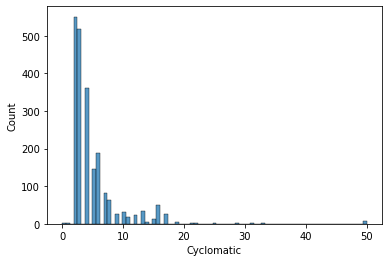

In [60]:
from imblearn.under_sampling import RandomUnderSampler

# usa técnica under-sampling
def under_sampling(d, seed = 0):
    ppc = d['PrimePathCoverage'].values
    rus = RandomUnderSampler(random_state=seed, sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(d['Name'].values.reshape(-1,1), d['Cyclomatic'].values)
    d['Selected'] = d['Name'].apply(lambda name: name in X_res)
    dataset_filtered = d[d['Selected']]
    dataset_filtered = dataset_filtered.drop('Selected', axis=1)
    d = d.drop('Selected', axis=1)
    
    return dataset_filtered

dataset_filtered = under_sampling(dataset, 0)
print('Dataset size: ', dataset_filtered.shape[0])
print('Média complexidade dataset: ', dataset['Cyclomatic'].mean())
print('Média complexidade dataset balanceado: ', dataset_filtered['Cyclomatic'].mean())
sns.histplot(dataset_filtered['Cyclomatic'])

## Funções uteis

In [116]:
from sklearn.preprocessing import MinMaxScaler

k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
]

def escalonador(dados):
    scaler = MinMaxScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset_filtered, k=10):
    ppc = d['PrimePathCoverage'].values.reshape(-1,1)
    previsores_content = d[previsores].values.reshape(-1,1)
    
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content).reshape(-1,1), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    #print(ppc)
    #print(previsores_content)
    print(resultados)
    
    print('-----< SEM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados['test_r2'].mean()))
    print('-----< COM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados_escalonados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados_escalonados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados_escalonados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados_escalonados['test_r2'].mean()))

In [72]:
dataset_filtered['EdgeCoverage'].values

array([1. , 1. , 1. , ..., 0.8, 0.8, 0.8])

## Experimentos

In [73]:
for previsor in previsores:
    print('PREVISOR ', previsor)
    evaluate([
        previsor
    ], LinearRegression(), dataset_filtered)
    print('\n')

PREVISOR  CountInput
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.2392149053219867
Mean Sqr Error:  0.08706245736424832
Mean Sqr Log Error:  0.03941400685955855
Mean Median Error:  0.2173938223474355
R2 Score:  0.23953649048468675
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.2392149053219867
Mean Sqr Error:  0.08706245736424834
Mean Sqr Log Error:  0.03941400685955855
Mean Median Error:  0.2173938223474355
R2 Score:  0.23953649048468675


PREVISOR  CountLine
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.14062780581253814
Mean Sqr Error:  0.04366343372088077
Mean Sqr Log Error:  0.019210560907397138
Mean Median Error:  0.11726094356616354
R2 Score:  0.09029855660105784
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.1406278058125381
Mean Sqr Error:  0.04366343372088077
Mean Sqr Log Error:  0.019210560907397138
Mean Median Error:  0.11726094356616354
R2 Score:  0.09029855660105782


PREVISOR  CountLineCode


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.0. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.1452230532646742
Mean Sqr Error:  0.04618751170958822
Mean Sqr Log Error:  0.0193482178835154
Mean Median Error:  0.13220079706826823
R2 Score:  0.06902735819557751
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.1452230532646742
Mean Sqr Error:  0.04618751170958822
Mean Sqr Log Error:  0.0193482178835154
Mean Median Error:  0.13220079706826823
R2 Score:  0.0690273581955775


PREVISOR  CountLineCodeDecl
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.19926190982351272
Mean Sqr Error:  0.0690330189846833
Mean Sqr Log Error:  0.03046995607010356
Mean Median Error:  0.16295439107911439
R2 Score:  0.06335676809351781
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.1992619098235127
Mean Sqr Error:  0.06903301898468328
Mean Sqr Log Error:  0.03046995607010356
Mean Median Error:  0.16295439107911436
R2 Score:  0.06335676809351773


PREVISOR  CountLineCodeExe
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.1450285842098547
Mean Sqr

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.0. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.15473051713561506
Mean Sqr Error:  0.053795561103580206
Mean Sqr Log Error:  0.023616375180594874
Mean Median Error:  0.14221094315318475
R2 Score:  0.07933956599682963
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.15473051713561506
Mean Sqr Error:  0.05379556110358019
Mean Sqr Log Error:  0.023616375180594874
Mean Median Error:  0.14221094315318475
R2 Score:  0.07933956599682956


PREVISOR  CountStmt
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.166604933351514
Mean Sqr Error:  0.05329168526817572
Mean Sqr Log Error:  0.02259395817371084
Mean Median Error:  0.15162052803829512
R2 Score:  0.1025535668209812
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.16660493335151402
Mean Sqr Error:  0.05329168526817574
Mean Sqr Log Error:  0.022593958173710838
Mean Median Error:  0.15162052803829515
R2 Score:  0.10255356682098116


PREVISOR  CountStmtDecl
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.20101012429838733
Mean Sqr E

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.0. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.0. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.16938330752768663
Mean Sqr Error:  0.05500395309493178
Mean Sqr Log Error:  0.02339481274114685
Mean Median Error:  0.15634747343413966
R2 Score:  0.062328839911846026
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.16938330752768666
Mean Sqr Error:  0.05500395309493178
Mean Sqr Log Error:  0.02339481274114685
Mean Median Error:  0.1563474734341396
R2 Score:  0.06232883991184605


PREVISOR  Cyclomatic
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.14645697911155656
Mean Sqr Error:  0.04702106972338679
Mean Sqr Log Error:  0.01966148354367229
Mean Median Error:  0.1363224076178706
R2 Score:  0.07472181256048929
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.14645697911155656
Mean Sqr Error:  0.04702106972338679
Mean Sqr Log Error:  0.01966148354367229
Mean Median Error:  0.13632240761787062
R2 Score:  0.07472181256048929


PREVISOR  CyclomaticModified
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.1471884774421288
Mean Sq

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.0. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.20365048621037948
Mean Sqr Error:  0.07406599807513545
Mean Sqr Log Error:  0.03283595419973962
Mean Median Error:  0.18570312054870602
R2 Score:  0.09448590608401566
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.20365048621037948
Mean Sqr Error:  0.07406599807513545
Mean Sqr Log Error:  0.032835954199739614
Mean Median Error:  0.18570312054870605
R2 Score:  0.09448590608401561


PREVISOR  EdgeCoverage
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.01990237606100496
Mean Sqr Error:  0.0046106190814507635
Mean Sqr Log Error:  0.002343525555974608
Mean Median Error:  0.01833380609122064
R2 Score:  0.11486053182591971
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.01990237606100493
Mean Sqr Error:  0.004610619081450755
Mean Sqr Log Error:  0.002343525555974604
Mean Median Error:  0.018333806091220605
R2 Score:  0.11486053182591935


PREVISOR  CountInput.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.22769726197661347
Me

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0.0. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.22628607180981097
Mean Sqr Error:  0.08306913509914102
Mean Sqr Log Error:  0.03741681539946416
Mean Median Error:  0.20025288201959485
R2 Score:  0.13678855053008734
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.22628607180981097
Mean Sqr Error:  0.08306913509914103
Mean Sqr Log Error:  0.03741681539946416
Mean Median Error:  0.20025288201959485
R2 Score:  0.1367885505300874


PREVISOR  CountLineCode.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.22776799532586273
Mean Sqr Error:  0.08463138206306829
Mean Sqr Log Error:  0.03808132925953883
Mean Median Error:  0.19855165413996173
R2 Score:  0.15409683450757886
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.22776799532586273
Mean Sqr Error:  0.08463138206306829
Mean Sqr Log Error:  0.03808132925953883
Mean Median Error:  0.19855165413996173
R2 Score:  0.1540968345075788


PREVISOR  CountLineCodeDecl.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.22605672612175892
M

In [106]:
d = dataset_filtered.iloc[:50, :]
print(d[d['PrimePathCoverage'] <= 0])
#evaluate([
#    'EdgeCoverage'
#], LinearRegression(), d)

'''
evaluate([
    'EdgeCoverage'
], LinearRegression(), dataset_filtered)
'''

Empty DataFrame
Columns: [Name, CountInput, CountLine, CountLineBlank, CountLineCode, CountLineCodeDecl, CountLineCodeExe, CountLineComment, CountOutput, CountPath, CountPathLog, CountSemicolon, CountStmt, CountStmtDecl, CountStmtExe, Cyclomatic, CyclomaticModified, CyclomaticStrict, Essential, Knots, MaxEssentialKnots, MaxNesting, MinEssentialKnots, RatioCommentToCode, Name.1, CountInput.1, CountLine.1, CountLineBlank.1, CountLineCode.1, CountLineCodeDecl.1, CountLineCodeExe.1, CountLineComment.1, CountOutput.1, CountPath.1, CountPathLog.1, CountSemicolon.1, CountStmt.1, CountStmtDecl.1, CountStmtExe.1, Cyclomatic.1, CyclomaticModified.1, CyclomaticStrict.1, Essential.1, Knots.1, MaxEssentialKnots.1, MaxNesting.1, MinEssentialKnots.1, RatioCommentToCode.1, EdgeCoverage, PrimePathCoverage]
Index: []

[0 rows x 50 columns]


"\nevaluate([\n    'EdgeCoverage'\n], LinearRegression(), dataset_filtered)\n"

In [115]:
evaluate([
    'Cyclomatic'
], LinearRegression(), d, 10)

{'fit_time': array([0.00113821, 0.0011909 , 0.00109124, 0.00065994, 0.00099683,
       0.0009973 , 0.00049567, 0.        , 0.00126576, 0.        ]), 'score_time': array([0.00286245, 0.00243306, 0.00280786, 0.00200272, 0.00199366,
       0.00199127, 0.00162292, 0.00260592, 0.00200272, 0.00199413]), 'estimator': [LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression(), LinearRegression()], 'test_r2': array([  0.24170089,          nan, -40.49519887,  -2.47970529,
         0.25759656,  -0.5742743 ,  -0.06115219,   0.35005391,
         0.27532706,  -0.21018951]), 'test_max_error': array([-0.16162228,         nan, -0.26427042, -0.25900812, -0.35249279,
       -0.45658722, -0.42883724, -0.35210231, -0.23634873, -0.37893186]), 'test_neg_mean_absolute_error': array([-0.11621186,         nan, -0.26286956, -0.22452638, -0.16773366,
       -0.31082622, -0.23099754, -0.19124343

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regres

In [11]:
evaluate([
    'MaxNesting'
], LinearRegression(), dataset_filtered)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.18359588500304527
Mean Sqr Error:  0.04829274074887772
Mean Sqr Log Error:  0.01813574011868239
Mean Median Error:  0.18245359430082836
R2 Score:  0.09233306442135311
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.18359588500304527
Mean Sqr Error:  0.04829274074887772
Mean Sqr Log Error:  0.01813574011868239
Mean Median Error:  0.18245359430082836
R2 Score:  0.09233306442135311


In [ ]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(
        hidden_layer_sizes=(122,), 
        activation='tanh', 
        learning_rate='invscaling', 
        alpha=0.1,
        random_state=0
), dataset_filtered)

In [ ]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset_filtered)

In [ ]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset_filtered)

In [ ]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset_filtered)